# Checking Kahlerity of CYmetric output

We use the numerical exterior derivative algorithm in [https://arxiv.org/abs/2510.00999](https://arxiv.org/abs/2510.00999) to check $d\omega =0$

In [ ]:
import sys, pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent  # LearningG2
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

# Import libraries
import tensorflow as tf
import numpy as np
import os
import yaml
import pickle as pickle
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

tfk = tf.keras
# Setup path for cymetric package

_parent_dir = pathlib.Path.cwd().parent.parent
_cymetric_dir = _parent_dir / "cymetric"

if str(_parent_dir) not in sys.path:
    sys.path.insert(0, str(_parent_dir))
if str(_cymetric_dir) not in sys.path:
    sys.path.insert(0, str(_cymetric_dir))

# Create alias to fix cymetric internal imports
import cymetric
if hasattr(cymetric, 'cymetric'):
    sys.modules['cymetric'] = cymetric.cymetric

# Import functions
from geometry.geometry import kahler_form_real_matrix, holomorphic_volume_real_imag, compute_gG2
# # from ..geometry.patches import CoordChange_C5R10
from geometry.wedge import wedge
# from models.model import get_model_path

# Import cymetric functions
from cymetric.pointgen.pointgen import PointGenerator
from cymetric.models.helper import prepare_basis
from cymetric.models.models import MultFSModel

PROJECT_ROOT: /Users/tomassilva/Desktop/GitHub/LearningG2


/opt/homebrew/Caskroom/miniforge/base/envs/g2_ml/lib/python3.9/importlib/__init__.py:127: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _bootstrap._gcd_import(name[level:], package, level)


## Loading the trained CYmetric model

In [ ]:
dirname = '../models/cy_models/train_data'

data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)

BASIS = prepare_basis(BASIS)

nlayer = 3
nHidden = 64
act = 'gelu'
nEpochs = 500
bSizes = [64, 50000]
alpha = [1., 1., 1., 1., 1.]
nfold = 3
n_in = 2*5
n_out = nfold**2

nn = tf.keras.Sequential()
nn.add(tfk.Input(shape=(n_in,)))
for i in range(nlayer):
    nn.add(tfk.layers.Dense(nHidden, activation=act))
nn.add(tfk.layers.Dense(n_out, use_bias=False))

loaded_nn = tf.keras.models.load_model("../models/cy_models/cy_metric_model.keras")
fmodel = MultFSModel(loaded_nn, BASIS, alpha=alpha)


## Utility functions to patch/sub-patch selection

In [2]:
def _find_max_dQ_coords(points):
    r"""Finds the coordinates for which |dQ/dz| is largest.

    Args:
        points (ndarray[(n_p, ncoords), np.complex128]): Points.

    Returns:
        ndarray[(n_p), np.int64]: max(dQdz) indices
    """
    dQdz = np.abs(_compute_dQdz(points))
    dQdz = dQdz * (~np.isclose(points, complex(1, 0)))
    return np.argmax(dQdz, axis=-1)

def _compute_dQdz(points):
        r"""Computes dQdz at each point.

        Args:
            points (ndarray([n_p, ncoords], np.complex128)): Points.

        Returns:
            ndarray([n_p, ncoords], np.complex): dQdz at each point.
        """
        p_exp = np.expand_dims(np.expand_dims(points, 1), 1)
        dQdz = np.power(p_exp, BASIS['DQDZB0'])
        dQdz = np.multiply.reduce(dQdz, axis=-1)
        dQdz = np.multiply(BASIS['DQDZF0'], dQdz)
        dQdz = np.add.reduce(dQdz, axis=-1)
        return dQdz
    


## Numerical exterior derivative routine in [https://arxiv.org/abs/2510.00999](https://arxiv.org/abs/2510.00999)

In [6]:
def quintic_solver(p, drop_max, drop_one):
    p_cc = p[0:3]+1.j*p[3:]
    new_dependent = (-1-p_cc[0]**5-p_cc[1]**5-p_cc[2]**5)**(1/5)
    
    ret = [None]*10
    ret[drop_one] = 1.0
    ret[drop_one+5] = 0.0
    
    ret[drop_max] = float(new_dependent.real)
    ret[drop_max+5] = float(new_dependent.imag)
    
    j=0
    for i in range(5):
        if ret[i] is None:
            ret[i] = float(p[j])
            ret[i+5] = float(p[j+3])
            j+=1
    return np.expand_dims(np.array(ret, dtype=np.float64), axis=0)
    

def sample_numerical_kform_neighborhood_val(sampler, point, epsilon=1e-12):
    """
    Sample numerical values of a k-form at a (cubic) neighborhood of a point
    :param sampler: function to sample the k-form
    :param point: point at which to sample (center of a cube)
    :param epsilon: distance from the point to the neighborhood points
    :return: numerical values of the k-form at the neighborhood points as a dictionary
    6-dimensional dictionary with keys '0' to '6', where '0' is the center point and '1' to '6' are the -+ epsilon* canonical basis vectors 
    """
    point_cc = point[0:5] + 1.j*point[5:]
    drop_max = int(_find_max_dQ_coords(point_cc))
    drop_one = int(np.argmin(np.abs(point_cc - 1)))
    p_cc = np.delete(point_cc, [drop_max, drop_one])
    
    # p = np.array(point)
    p = np.concatenate([p_cc.real, p_cc.imag])
    
    directions = [np.array(np.eye(6, dtype=int)[i]) for i in range(6)]
    
    values = {"0": [sampler(quintic_solver(p, drop_max, drop_one))],
            "1": [sampler(quintic_solver(p - epsilon*directions[0], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[0], drop_max, drop_one))],
            "2": [sampler(quintic_solver(p - epsilon*directions[1], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[1], drop_max, drop_one))],
            "3": [sampler(quintic_solver(p - epsilon*directions[2], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[2], drop_max, drop_one))],
            "4": [sampler(quintic_solver(p - epsilon*directions[3], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[3], drop_max, drop_one))],
            "5": [sampler(quintic_solver(p - epsilon*directions[4], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[4], drop_max, drop_one))],
            "6": [sampler(quintic_solver(p - epsilon*directions[5], drop_max, drop_one)), sampler(quintic_solver(p + epsilon*directions[5], drop_max, drop_one))],
            
            } 
            
    return values
    
def numerical_d(k_form_neighborhood_vals, e=1e-12):
    # d\omega_p(X_0, ..., X_k) \approx \frac{1}{\text{vol}(\sigma)} \int_{\partial \sigma} \omega 
    # where \sigma is a small k-dimensional block generated by X_0, ..., X_k
    # ----
    # Also, remember g_{ij}(x) = \delta_{ij} - \frac{1}{3} R_{ikjl}(0) \, x^k x^l + \mathcal{O}(|x|^3) = 
    #                          =\delta_{ij} + \mathcal{O}(|x|^3), 
    # since R_{ikjl} = 0 for Ricci-flat manifolds (which we assume here)
    # Thus, the volume of the k-dimensional block is approximately (2e)^k 
    # ----
    # Note for future Tomas: (-1)xSign convention of Acker's Book!
    """
    Compute the numerical exterior derivative of a k-form at a point using neighborhood values
    :param k_form_neighborhood_vals: dictionary of neighborhood values of the k-form
    :param g: metric tensor (needed for computing hypercube volume)
    :param e: small value to approximate the derivative
    :return: numerical exterior derivative of the k-form a the point k_form_neighborhood_vals["0"] as a numpy array
    """
    
    k = len(k_form_neighborhood_vals["0"][0].shape)
    
    # If the k-form is a 0-form (scalar field)
    if k == 0: 
        dw = np.zeros(6)
        for i in range(6):
            dw[i] = (1/(2*e))*(k_form_neighborhood_vals[str(i+1)][1] - k_form_neighborhood_vals[str(i+1)][0])
        return dw
    
    # If the k-form is a 1-form
    elif k == 1:
        dw = np.zeros((6,6))
        for i in range(6):
            for j in range(6):
                if i!=j:
                    dw[i,j] = (1/(2*e))*(k_form_neighborhood_vals[str(j+1)][0][i] +\
                                                k_form_neighborhood_vals[str(i+1)][1][j] -\
                                                k_form_neighborhood_vals[str(j+1)][1][i] -\
                                                k_form_neighborhood_vals[str(i+1)][0][j])
        
        return dw
    
    # If the k-form is a 2-form
    elif k == 2:
        dw = np.zeros((6,6,6))      
        for i in range(6):
            for j in range(6):
                for k in range(6):
                    if i!=j and j!=k and i!=k:
                        dw[i,j,k] = (1/(2*e))*(+k_form_neighborhood_vals[str(i+1)][1][j,k] -\
                                                k_form_neighborhood_vals[str(i+1)][0][j,k] -\
                                                k_form_neighborhood_vals[str(j+1)][1][i,k] +\
                                                k_form_neighborhood_vals[str(j+1)][0][i,k] +\
                                                k_form_neighborhood_vals[str(k+1)][1][i,j] -\
                                                k_form_neighborhood_vals[str(k+1)][0][i,j])
        return dw

    elif k >= 3:
        raise NotImplementedError("Numerical exterior derivative for k-forms with k >= 3 is not implemented.")   

In [7]:
def sampler_2form(p):
    return kahler_form_real_matrix(np.array(fmodel(p)[0]))

## We compute $d\omega$ over the CYmetric train and test datasets

Computing d\omega: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


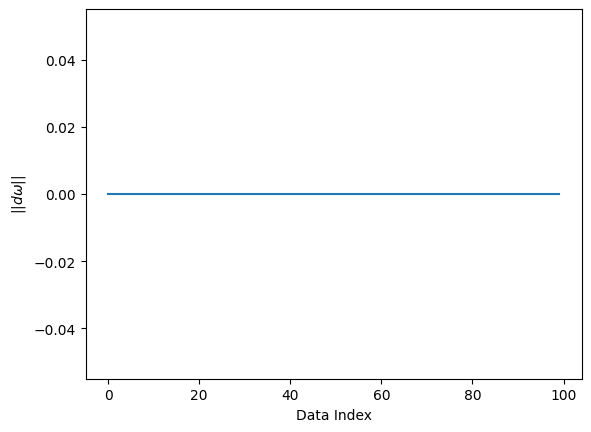

In [13]:
vals = []
# for i in tqdm(range(len(data['X_train'])), desc="Computing d\omega"):
for i in tqdm(range(100), desc="Computing d\omega"):
    point = data['X_train'][i]
    dic2_form = sample_numerical_kform_neighborhood_val(sampler_2form, point)
    numerical_exterior_d = numerical_d(dic2_form)
    
    vals.append(np.linalg.norm(numerical_exterior_d))
    
plt.plot(vals)
plt.xlabel("Data Index")
plt.ylabel(r"$||d\omega||$")
plt.show()
    

Computing d\omega: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


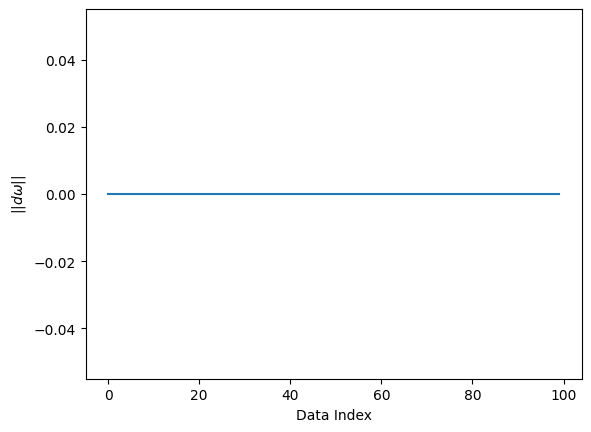

In [14]:
vals = []
# for i in tqdm(range(len(data['X_val'])), desc="Computing d\omega"):
for i in tqdm(range(100), desc="Computing d\omega"):
    point = data['X_val'][i]
    dic2_form = sample_numerical_kform_neighborhood_val(sampler_2form, point)
    numerical_exterior_d = numerical_d(dic2_form)
    
    vals.append(np.linalg.norm(numerical_exterior_d))
    
plt.plot(vals)
plt.xlabel("Data Index")
plt.ylabel(r"$||d\omega||$")
plt.show()